# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.random.set_seed(30)
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images))
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [4]:
# define the path where training and validation data are placed.
SOURCE_PATH = os.getcwd()

# Training data constants
TRAIN_DATA_PATH = SOURCE_PATH + '/Project_data/train'
TRAIN_DATA_CSV = SOURCE_PATH + '/Project_data/train.csv'

# Validation data constants
VALIDATION_DATA_PATH = SOURCE_PATH + '/Project_data/val'
VALIDATION_DATA_CSV = SOURCE_PATH + '/Project_data/val.csv'

NUM_CLASSES = 5

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
TRAIN_DOC = np.random.permutation(open(TRAIN_DATA_CSV).readlines())
VALIDATION_DOC = np.random.permutation(open(VALIDATION_DATA_CSV).readlines())

print("Training data size = {}".format(len(TRAIN_DOC)))
print("Validation data size = {}".format(len(VALIDATION_DOC)))

Training data size = 663
Validation data size = 100


---
### Choosing Frame Dimenstion:

- Lets visualize 360x360 and 120x160 image in different dimension as below:
    - 360x360
    - 240x240
    - 120x120

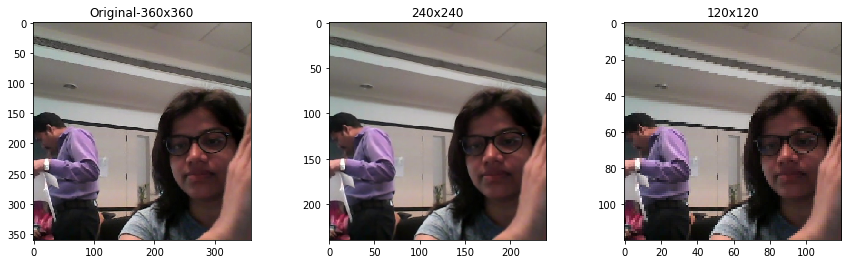

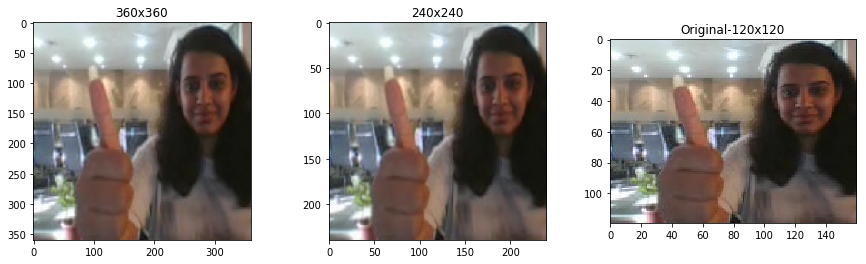

In [6]:
# below is 360x360 image frame
largeSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png'),
    cv2.COLOR_BGR2RGB)

# below is 120x160 image frame
smallSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png'),
    cv2.COLOR_BGR2RGB)

# resize of 360x360 image and plot
largeSizeImageResizeTo120 = cv2.resize(largeSizeImage, (120, 120))
largeSizeImageResizeTo240 = cv2.resize(largeSizeImage, (240, 240))
plot_image([largeSizeImage, largeSizeImageResizeTo240, largeSizeImageResizeTo120],
           captions = ["Original-360x360", "240x240", "120x120" ])

# resize of 120x160 image and plot
smallSizeImageResizeTo320 = cv2.resize(smallSizeImage, (360, 360))
smallSizeImageResizeTo240 = cv2.resize(smallSizeImage, (240, 240))
plot_image([smallSizeImageResizeTo320, smallSizeImageResizeTo240, smallSizeImage ],
           captions = ["360x360", "240x240" , "Original-120x120"])

- 240x240 dimension image seems to be good options in terms of picture clarity. Hence we would be resizing all the images to this.

In [7]:
VIDEO_FRAME_COUNT = 30
CLASS_COUNT = 5
FRAME_RESIZE_DIMENSION = (120, 120)
FRAME_RESIZE_CROP_DIMENSION = (100, 100)

---

### Possible Augmentations:
`Flipping`: `No`
- Up-down flip of frame will not be helpful
- Left-Right flip incase of fast forward or backward will consfuse the model


`Rotation` : `No`
- Rotating to certain angle is quite possible, but we would prefer no to use as data would already have certain degree of rotation.

`Cropping` : `No`
- Certain User actions like fast forward and backward, certain frames are around the edges. Hence good to avoid.

`Scaling` : `Yes`
- We are using this for resizing the image to common dimenstion(240x240) and can be feeded to model.

`Translation` : `No`
- With given problem statement, translating the frames may break the sequence of action which model actually needs to learn. 

In [8]:
class FrameProcessing():
    
    def __init__(self, path):
        """
            When the image file is read with the OpenCV function imread(), the order of colors is BGR.
            Hence changing it to RGB
        """
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    def get(self):
        """get the image array"""
        return self.image
    
    def resize(self):
        """ resize the image to 120x120 """
        self.image = cv2.resize(self.image, FRAME_RESIZE_DIMENSION, interpolation=cv2.INTER_AREA)
        return self
    
    def crop (self):
        """crop the image"""
        self.image = self.image[10:110, 10:110]
        return self;
    
    def normalization(self):
        """normalize the image by dividing by 255"""
        self.image = self.image/255
        return self
        

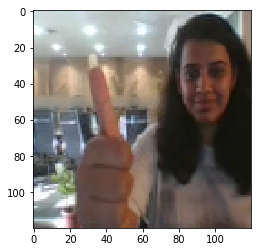

In [9]:
# Lets visualize an image
img = FrameProcessing(
    TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png').resize()
plt.imshow(img.get())

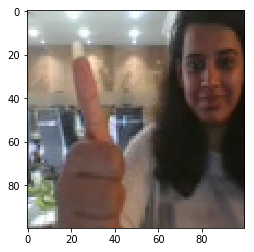

In [10]:
plt.imshow(img.crop().get())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size, crop=False):
    img_idx = list(range(0, VIDEO_FRAME_COUNT, 1))
    while True:
        t = np.random.permutation(folder_list)

        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            if crop == True:
                batch_data = np.zeros((batch_size,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_CROP_DIMENSION[0],FRAME_RESIZE_CROP_DIMENSION[1],3))
            else:
                batch_data = np.zeros((batch_size,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_DIMENSION[0],FRAME_RESIZE_DIMENSION[1],3))

            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):                    
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize as discussed above
                    imageObj.resize()
                    if crop == True:
                        imageObj.crop()
                    imageObj.normalization()
                    
                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        
        # remaining data points which are left after full batches
        remaining_folder = len(t)%batch_size
        if (remaining_folder > 0):
            if crop == True:
                batch_data = np.zeros((remaining_folder,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_CROP_DIMENSION[0],FRAME_RESIZE_CROP_DIMENSION[1],3))
            else:
                batch_data = np.zeros((remaining_folder,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_DIMENSION[0],FRAME_RESIZE_DIMENSION[1],3))
            
            batch_labels = np.zeros((remaining_folder,5))
            for folder in range(0, remaining_folder):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize as discussed above
                    imageObj.resize()
                    if crop == True:
                        imageObj.crop()
                    imageObj.normalization()

                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(TRAIN_DOC)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(VALIDATION_DOC)
print('# Validation sequences =', num_val_sequences)

# Training sequences = 663
# Validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Dropout, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50


def model_callbacks(model_checkpoint_name):
    model_name = model_checkpoint_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

---

## Evaluate batch size:

In [14]:
def get_sample_model():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [15]:
get_sample_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 64)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 64)     110656    
__________

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:

# num_epochs = 2

# for batch_size in range (20, 19, -10):
#     print("*********************************************")
#     print("FOR BATCH SIZE :", batch_size)
    
#     try: 
#         train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, batch_size)
#         val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, batch_size)

#         if (num_val_sequences%batch_size) == 0:
#             validation_steps = int(num_val_sequences/batch_size)
#             steps_per_epoch = int(num_train_sequences/batch_size)
#         else:
#             validation_steps = (num_val_sequences//batch_size) + 1
#             steps_per_epoch = (num_train_sequences//batch_size) + 1

#         get_sample_model().fit_generator(train_generator, 
#                                          steps_per_epoch=steps_per_epoch, 
#                                          epochs=num_epochs, 
#                                          verbose=1,
#                                          validation_data=val_generator, 
#                                          validation_steps=validation_steps, 
#                                          class_weight=None, 
#                                          workers=1, 
#                                          initial_epoch=0)
#     except:
#         print("OOM error for Batch size:" , batch_size)
    

In [17]:
BATCH_SIZE = 20;

In [18]:
if (num_train_sequences%BATCH_SIZE) == 0:
    steps_per_epoch = int(num_train_sequences/BATCH_SIZE)
else:
    steps_per_epoch = (num_train_sequences//BATCH_SIZE) + 1

if (num_val_sequences%BATCH_SIZE) == 0:
    validation_steps = int(num_val_sequences/BATCH_SIZE)
else:
    validation_steps = (num_val_sequences//BATCH_SIZE) + 1

--- 

# Model: Conv3D

In [19]:
Conv3DModel = Sequential()
Conv3DModel.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel.add(Activation('relu'))
Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel.add(Activation('relu'))
Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel.add(Activation('relu'))
Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel.add(Flatten())
Conv3DModel.add(Dense(64, activation='relu'))
Conv3DModel.add(Dropout(0.25))

Conv3DModel.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 64)    0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 30, 30, 64)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 30, 30, 64)     110656    
__________

In [20]:
# num_epochs= 10

# train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
# val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

# history = Conv3DModel.fit_generator(
#     train_generator, 
#     steps_per_epoch=steps_per_epoch, 
#     epochs=num_epochs, 
#     verbose=1,
#     callbacks=model_callbacks('Conv3DModel'),
#     validation_data=val_generator, 
#     validation_steps=validation_steps, 
#     class_weight=None, 
#     workers=1, 
#     initial_epoch=0)

# plot(history)

---

# Model: Conv3D with cropping

In [21]:
Conv3DModel_With_Crop = Sequential()
Conv3DModel_With_Crop.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_CROP_DIMENSION[0], FRAME_RESIZE_CROP_DIMENSION[1], 3)))
Conv3DModel_With_Crop.add(Activation('relu'))
Conv3DModel_With_Crop.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_Crop.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_Crop.add(Activation('relu'))
Conv3DModel_With_Crop.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_Crop.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_Crop.add(Activation('relu'))
Conv3DModel_With_Crop.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_Crop.add(Flatten())
Conv3DModel_With_Crop.add(Dense(64, activation='relu'))
Conv3DModel_With_Crop.add(Dropout(0.25))

Conv3DModel_With_Crop.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_Crop.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_Crop.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 100, 100, 32)  2624      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 50, 50, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 50, 50, 64)    55360     
_________________________________________________________________
activation_9 (Activation)    (None, 15, 50, 50, 64)    0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 25, 25, 64)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 25, 25, 64)     110656    
__________

In [22]:
# num_epochs= 20

# train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE, crop=True)
# val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, crop=True)

# history = Conv3DModel_With_Crop.fit_generator(
#     train_generator, 
#     steps_per_epoch=steps_per_epoch, 
#     epochs=num_epochs, 
#     verbose=1,
#     callbacks=model_callbacks('Conv3DModel_Cropping'),
#     validation_data=val_generator, 
#     validation_steps=validation_steps, 
#     class_weight=None, 
#     workers=1, 
#     initial_epoch=0)

# plot(history)

# Model: Conv3D with Filter size(3,3,3) and Batch Normalization

In [23]:
Conv3DModel_With_BN = Sequential()
Conv3DModel_With_BN.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel_With_BN.add(Activation('relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN.add(Activation('relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN.add(Activation('relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN.add(Flatten())
Conv3DModel_With_BN.add(Dense(64, activation='relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(Dropout(0.25))

Conv3DModel_With_BN.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_BN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_BN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_11 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_12 (Activation)   (None, 15, 60, 60, 64)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 163s 5s/step - loss: 1.4225 - categorical_accuracy: 0.4511 - val_loss: 1.8359 - val_categorical_accuracy: 0.5000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.50000, saving model to Conv3DModel_With_BN_2020-03-1608_44_54.438267/model-00001-1.39372-0.45400-1.83589-0.50000.h5
Epoch 2/20
34/34 [==============================] - 58s 2s/step - loss: 0.9204 - categorical_accuracy: 0.6497 - val_loss: 1.3910 - val_categorical_accuracy: 0.4600

Epoch 00002: val_categorical_accuracy did not improve from 0.50000
Epoch 3/20
34/34 [==============================] - 59s 2s/step - loss: 0.6234 - categorical_accuracy: 0.7741 - val_loss: 0.8337 - val_categorical_accuracy: 0.7200

Epoch 00003: val_categorical_accuracy improved from 0.50000 to 0.72000, saving model to Conv3DModel_With_BN_2020-03-1608_44_54.438267/model-00003-0.62480-0.77677-0.83374-0.72000.h5
Epoch 4/20
34/34 [==============================] - 57s 2s/step - loss: 0.4564

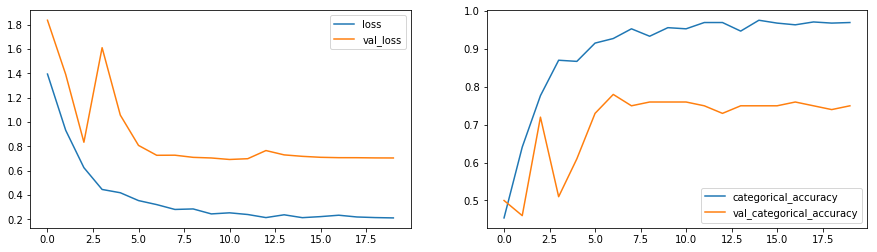

In [24]:
num_epochs= 20

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModel_With_BN.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

# Model: Conv3D with Filter size(3,3,3), Batch Normalization and Dropout

In [25]:
Conv3DModel_With_BN_DP = Sequential()
Conv3DModel_With_BN_DP.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel_With_BN_DP.add(Activation('relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_DP.add(Activation('relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_DP.add(Activation('relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Flatten())
Conv3DModel_With_BN_DP.add(Dense(64, activation='relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.01, decay=1e-6, nesterov=True)
Conv3DModel_With_BN_DP.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_BN_DP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_15 (Activation)   (None, 15, 60, 60, 64)    0         
__________

Epoch 1/20
34/34 [==============================] - 61s 2s/step - loss: 1.5029 - categorical_accuracy: 0.4224 - val_loss: 1.9343 - val_categorical_accuracy: 0.3900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.39000, saving model to Conv3DModel_With_BN_DP_2020-03-1608_44_54.438267/model-00001-1.51150-0.41629-1.93429-0.39000.h5
Epoch 2/20
34/34 [==============================] - 57s 2s/step - loss: 1.1013 - categorical_accuracy: 0.5644 - val_loss: 1.5442 - val_categorical_accuracy: 0.4900

Epoch 00002: val_categorical_accuracy improved from 0.39000 to 0.49000, saving model to Conv3DModel_With_BN_DP_2020-03-1608_44_54.438267/model-00002-1.09598-0.57014-1.54423-0.49000.h5
Epoch 3/20
34/34 [==============================] - 57s 2s/step - loss: 0.8971 - categorical_accuracy: 0.6453 - val_loss: 1.4193 - val_categorical_accuracy: 0.5100

Epoch 00003: val_categorical_accuracy improved from 0.49000 to 0.51000, saving model to Conv3DModel_With_BN_DP_2020-03-1608_44_54.438267/mod

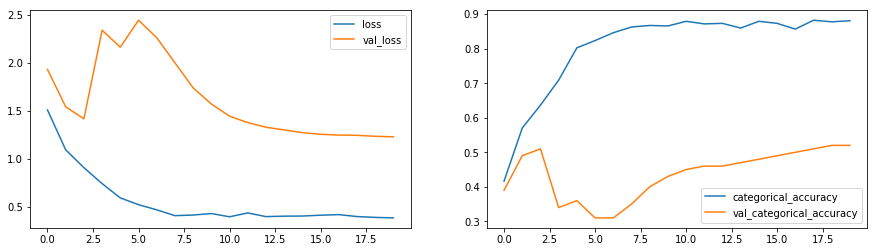

In [26]:
num_epochs= 20

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModel_With_BN_DP.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_BN_DP'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

# Model: Conv3D with Cropping, Filter size(3,3,3) and Batch Normalization

In [27]:
Conv3DModel_With_C_BN = Sequential()
Conv3DModel_With_C_BN.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_CROP_DIMENSION[0], FRAME_RESIZE_CROP_DIMENSION[1], 3)))
Conv3DModel_With_C_BN.add(Activation('relu'))
Conv3DModel_With_C_BN.add(BatchNormalization())
Conv3DModel_With_C_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_C_BN.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_C_BN.add(Activation('relu'))
Conv3DModel_With_C_BN.add(BatchNormalization())
Conv3DModel_With_C_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_C_BN.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_C_BN.add(Activation('relu'))
Conv3DModel_With_C_BN.add(BatchNormalization())
Conv3DModel_With_C_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_C_BN.add(Flatten())
Conv3DModel_With_C_BN.add(Dense(64, activation='relu'))
Conv3DModel_With_C_BN.add(BatchNormalization())
Conv3DModel_With_C_BN.add(Dropout(0.25))

Conv3DModel_With_C_BN.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_C_BN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_C_BN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 100, 100, 32)  2624      
_________________________________________________________________
activation_17 (Activation)   (None, 30, 100, 100, 32)  0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 50, 50, 32)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 50, 50, 64)    55360     
_________________________________________________________________
activation_18 (Activation)   (None, 15, 50, 50, 64)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 50, 50, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 50s 1s/step - loss: 1.5198 - categorical_accuracy: 0.4025 - val_loss: 1.6419 - val_categorical_accuracy: 0.5100

Epoch 00001: val_categorical_accuracy improved from -inf to 0.51000, saving model to Conv3DModel_With_Cropping_BN_2020-03-1608_44_54.438267/model-00001-1.53692-0.40422-1.64191-0.51000.h5
Epoch 2/20
34/34 [==============================] - 44s 1s/step - loss: 0.9191 - categorical_accuracy: 0.6475 - val_loss: 1.2339 - val_categorical_accuracy: 0.5200

Epoch 00002: val_categorical_accuracy improved from 0.51000 to 0.52000, saving model to Conv3DModel_With_Cropping_BN_2020-03-1608_44_54.438267/model-00002-0.91047-0.64706-1.23388-0.52000.h5
Epoch 3/20
34/34 [==============================] - 45s 1s/step - loss: 0.7023 - categorical_accuracy: 0.7307 - val_loss: 1.8518 - val_categorical_accuracy: 0.3500

Epoch 00003: val_categorical_accuracy did not improve from 0.52000
Epoch 4/20
34/34 [==============================] - 45s 1s/st

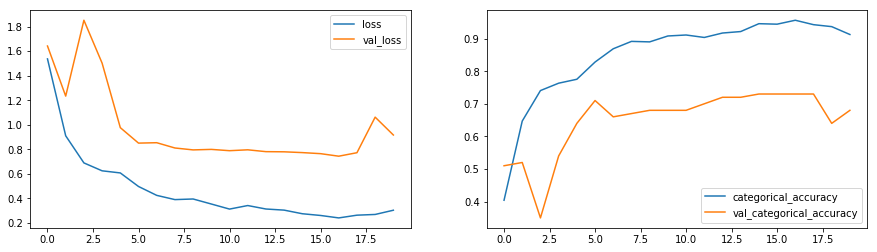

In [28]:
num_epochs= 20

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE, crop=True)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, crop=True)

history = Conv3DModel_With_C_BN.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_Cropping_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

# Model: Conv3D with Cropping, Filter size(3,3,3), Batch Normalization and Dropouts 

In [29]:
Conv3DModel_With_C_BN_DP = Sequential()
Conv3DModel_With_C_BN_DP.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_CROP_DIMENSION[0], FRAME_RESIZE_CROP_DIMENSION[1], 3)))
Conv3DModel_With_C_BN_DP.add(Activation('relu'))
Conv3DModel_With_C_BN_DP.add(BatchNormalization())
Conv3DModel_With_C_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_C_BN_DP.add(Dropout(0.25))

Conv3DModel_With_C_BN_DP.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_C_BN_DP.add(Activation('relu'))
Conv3DModel_With_C_BN_DP.add(BatchNormalization())
Conv3DModel_With_C_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_C_BN_DP.add(Dropout(0.25))

Conv3DModel_With_C_BN_DP.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_C_BN_DP.add(Activation('relu'))
Conv3DModel_With_C_BN_DP.add(BatchNormalization())
Conv3DModel_With_C_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_C_BN_DP.add(Dropout(0.25))

Conv3DModel_With_C_BN_DP.add(Flatten())
Conv3DModel_With_C_BN_DP.add(Dense(64, activation='relu'))
Conv3DModel_With_C_BN_DP.add(BatchNormalization())
Conv3DModel_With_C_BN_DP.add(Dropout(0.25))

Conv3DModel_With_C_BN_DP.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.01, decay=1e-6, nesterov=True)
Conv3DModel_With_C_BN_DP.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_C_BN_DP.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 100, 100, 32)  2624      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 100, 100, 32)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 15, 50, 50, 32)    0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 50, 50, 32)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 50, 50, 64)    55360     
_________________________________________________________________
activation_21 (Activation)   (None, 15, 50, 50, 64)    0         
__________

Epoch 1/20
34/34 [==============================] - 49s 1s/step - loss: 1.4529 - categorical_accuracy: 0.4253 - val_loss: 1.6766 - val_categorical_accuracy: 0.4300

Epoch 00001: val_categorical_accuracy improved from -inf to 0.43000, saving model to Conv3DModel_With_Cropping_BN_DP_2020-03-1608_44_54.438267/model-00001-1.47676-0.41931-1.67661-0.43000.h5
Epoch 2/20
34/34 [==============================] - 44s 1s/step - loss: 1.0059 - categorical_accuracy: 0.6078 - val_loss: 1.9908 - val_categorical_accuracy: 0.3800

Epoch 00002: val_categorical_accuracy did not improve from 0.43000
Epoch 3/20
34/34 [==============================] - 46s 1s/step - loss: 0.8477 - categorical_accuracy: 0.7012 - val_loss: 3.4169 - val_categorical_accuracy: 0.4000

Epoch 00003: val_categorical_accuracy did not improve from 0.43000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 4/20
34/34 [==============================] - 46s 1s/step - loss: 0.7276 - categorical_accurac

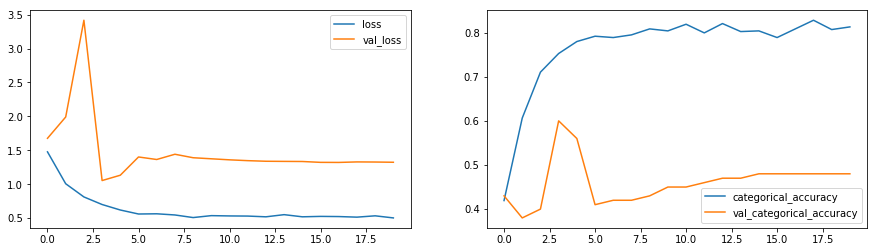

In [30]:
num_epochs= 20

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE, crop=True)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, crop=True)

history = Conv3DModel_With_C_BN_DP.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_Cropping_BN_DP'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

# Model: Conv3D Filter size(2,2,2) and Batch Normalization

In [31]:
Conv3DModel_With_BN_F = Sequential()
Conv3DModel_With_BN_F.add(Conv3D(32, (2, 2, 2), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel_With_BN_F.add(Activation('relu'))
Conv3DModel_With_BN_F.add(BatchNormalization())
Conv3DModel_With_BN_F.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_F.add(Conv3D(64, (2, 2, 2), padding='same'))
Conv3DModel_With_BN_F.add(Activation('relu'))
Conv3DModel_With_BN_F.add(BatchNormalization())
Conv3DModel_With_BN_F.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_F.add(Conv3D(64, (2, 2, 2), padding='same'))
Conv3DModel_With_BN_F.add(Activation('relu'))
Conv3DModel_With_BN_F.add(BatchNormalization())
Conv3DModel_With_BN_F.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_F.add(Flatten())
Conv3DModel_With_BN_F.add(Dense(64, activation='relu'))
Conv3DModel_With_BN_F.add(BatchNormalization())
Conv3DModel_With_BN_F.add(Dropout(0.25))

Conv3DModel_With_BN_F.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_BN_F.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_BN_F.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 30, 120, 120, 32)  800       
_________________________________________________________________
activation_23 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 15, 60, 60, 64)    16448     
_________________________________________________________________
activation_24 (Activation)   (None, 15, 60, 60, 64)    0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 60, 60, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 54s 2s/step - loss: 1.5803 - categorical_accuracy: 0.4032 - val_loss: 2.9795 - val_categorical_accuracy: 0.3200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.32000, saving model to Conv3DModel_With_fiterchange_BN_2020-03-1608_44_54.438267/model-00001-1.57004-0.41327-2.97950-0.32000.h5
Epoch 2/20
34/34 [==============================] - 47s 1s/step - loss: 0.8568 - categorical_accuracy: 0.6674 - val_loss: 1.1686 - val_categorical_accuracy: 0.5600

Epoch 00002: val_categorical_accuracy improved from 0.32000 to 0.56000, saving model to Conv3DModel_With_fiterchange_BN_2020-03-1608_44_54.438267/model-00002-0.84578-0.67572-1.16865-0.56000.h5
Epoch 3/20
34/34 [==============================] - 49s 1s/step - loss: 0.6435 - categorical_accuracy: 0.7645 - val_loss: 0.9842 - val_categorical_accuracy: 0.6500

Epoch 00003: val_categorical_accuracy improved from 0.56000 to 0.65000, saving model to Conv3DModel_With_fiterchange_BN_20

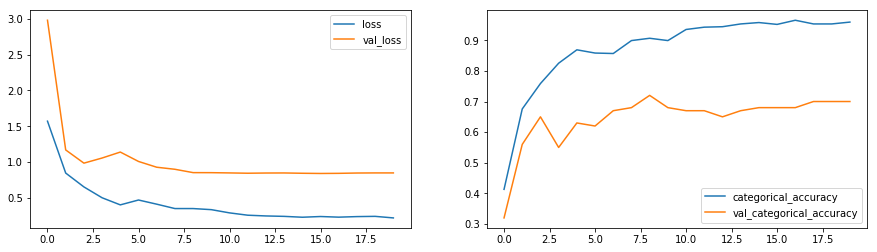

In [32]:
num_epochs= 20

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModel_With_BN_F.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_fiterchange_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---

# Model: Conv3D Filter with size(3,3,3), Batch Normalization and More Layers

In [33]:
Conv3DModel_With_BN_L = Sequential()
Conv3DModel_With_BN_L.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel_With_BN_L.add(Activation('relu'))
Conv3DModel_With_BN_L.add(BatchNormalization())
Conv3DModel_With_BN_L.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_L.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_L.add(Activation('relu'))
Conv3DModel_With_BN_L.add(BatchNormalization())
Conv3DModel_With_BN_L.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_L.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_L.add(Activation('relu'))
Conv3DModel_With_BN_L.add(BatchNormalization())
Conv3DModel_With_BN_L.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_L.add(Conv3D(128, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_L.add(Activation('relu'))
Conv3DModel_With_BN_L.add(BatchNormalization())
Conv3DModel_With_BN_L.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN_L.add(Flatten())
Conv3DModel_With_BN_L.add(Dense(64, activation='relu'))
Conv3DModel_With_BN_L.add(BatchNormalization())
Conv3DModel_With_BN_L.add(Dropout(0.25))

Conv3DModel_With_BN_L.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_BN_L.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_BN_L.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_26 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_27 (Activation)   (None, 15, 60, 60, 64)    0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 60, 60, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 62s 2s/step - loss: 1.7076 - categorical_accuracy: 0.3466 - val_loss: 3.6896 - val_categorical_accuracy: 0.3100

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31000, saving model to Conv3DModel_MoreLayers_and_BN_2020-03-1608_44_54.438267/model-00001-1.72681-0.34691-3.68959-0.31000.h5
Epoch 2/20
34/34 [==============================] - 57s 2s/step - loss: 1.2515 - categorical_accuracy: 0.5107 - val_loss: 1.2077 - val_categorical_accuracy: 0.5500

Epoch 00002: val_categorical_accuracy improved from 0.31000 to 0.55000, saving model to Conv3DModel_MoreLayers_and_BN_2020-03-1608_44_54.438267/model-00002-1.26628-0.50679-1.20771-0.55000.h5
Epoch 3/20
34/34 [==============================] - 57s 2s/step - loss: 0.8424 - categorical_accuracy: 0.6416 - val_loss: 1.2471 - val_categorical_accuracy: 0.5300

Epoch 00003: val_categorical_accuracy did not improve from 0.55000
Epoch 4/20
34/34 [==============================] - 57s 2s/

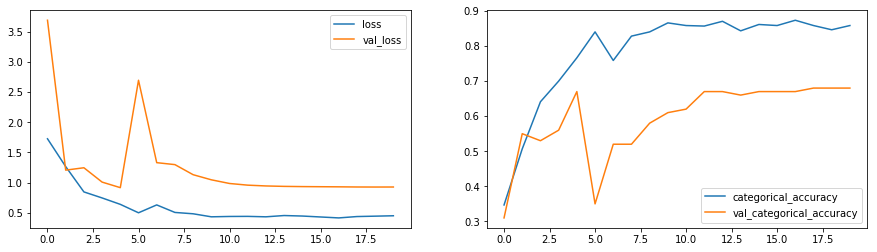

In [34]:
num_epochs= 20

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModel_With_BN_L.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_MoreLayers_and_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)